# Proyecto de clasificación Churn

**Onjetivo:** Predecir si un cliente se dará de baja (churn) o permanecerá en el servicio (problema de clasificación).

## 1 Carga y exploración inicial de los datos

### 1.1 Cargar librerías

In [7]:
# 🔧 Manipulación de datos
import pandas as pd
import numpy as np


# 📊 Visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline

# 🧼 Preprocesamiento
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from scipy.stats import zscore

# 🔍 Selección de características
from sklearn.feature_selection import SelectKBest, f_classif
# from boruta import BorutaPy (no se puede instalar en la plataforma)
# import shap (no se puede instalar en la plataforma)

# 🤖 Modelado
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# 🧪 Evaluación
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# 🧱 Utilidades
import os
import warnings
warnings.filterwarnings('ignore')
import time

print('Librerías cargadas exitosamente.')


Librerías cargadas exitosamente.


### 1.2 Función para eliminar varibales del entorno
Esta función será usada en el caso de que los recuros computacionales se vean afectados de manera notable en su rendimiento.

In [8]:
# Función para borar variables
def delete_vars(*names):
    """
    Elimina variables del entorno global que ya no se están utilizando.
    Parámetros:
    - nombres: lista de nombres de variables como strings.
    
    Ejemplo:
    borrar_variables('df_temp', 'X_unused')
    """
    for name in names:
        if name in globals():
            del globals()[name]
            print(f"✅ Variable '{name}' eliminada.")
        else:
            print(f"⚠️ Variable '{name}' no existe en el entorno.")

print ('Uso de la función delete_vars() para eliminar variables de entorno: \n \
    Ejemplo: delete_vars("df_temp", "X_unused")')


Uso de la función delete_vars() para eliminar variables de entorno: 
     Ejemplo: delete_vars("df_temp", "X_unused")


### 1.3 Cargar archivos y primera muestra para análisis

In [9]:
# Ruta de los archivos

folder_path = "../data"

# Listado de archivos en la carpeta
files = os.listdir(folder_path)
print("Files in folder:")
for f in files:
    print(f)

# Carga de archivos CSV
dataframes = {}
for f in files:
    file_path = os.path.join(folder_path, f)
    if f.endswith(".csv"):
        df = pd.read_csv(file_path)
        print(f"\n--- {f} ---")
        display(df.info())
        display(df.head())
        dataframes[f.replace('.csv', '')] = df  # Guardamos con nombre limpio

Files in folder:
contract.csv
internet.csv
personal.csv
phone.csv

--- contract.csv ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



--- internet.csv ---


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



--- personal.csv ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



--- phone.csv ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


### Hallazgos del análisis preliminar

- **Inconsistencia en registros entre archivos:**
    - contract.csv y personal.csv contienen 7043 registros, lo que sugiere que representan el universo completo de clientes.
    - phone.csv tiene solo 6361 registros y internet.csv 5517, lo que indica que no todos los clientes tienen servicios telefónicos o de internet. Esto requerirá imputación o codificación adecuada tras el merge.
- **Variable objetivo ausente:**
    - No existe una columna explícita llamada Churn. Sin embargo, se puede inferir a partir de la columna EndDate, donde los valores nulos indican que el cliente sigue activo. Se propone crear la variable Churn como:
    
    df['Churn'] = df['EndDate'].notnull().astype(int)
- **Formato incorrecto en TotalCharges:**
    - Aunque representa un valor numérico, esta columna está en formato object, lo que sugiere que contiene valores no convertibles (como espacios vacíos o texto). Será necesario limpiarla y convertirla a float.
- **Variables categóricas y binarias en texto:**
    - Columnas como gender, Partner, Dependents, PaperlessBilling, etc., están en formato texto y deberán codificarse correctamente (Label Encoding o One-Hot Encoding según el caso).
- **Posible desbalance en la variable Churn (por confirmar)**:
    - Una vez creada, será importante verificar si hay desbalance entre clases, lo que afectaría la elección de métricas y técnicas de modelado.


## 2 Unión de datasets y creación de la variable objetivo

### 2.1 Unir datasets

In [10]:
# 🔗 Unión de los datasets usabdo customerID como clave principal

df = dataframes['contract']\
    .merge(dataframes['personal'], on='customerID', how='left') \
    .merge(dataframes['phone'], on='customerID', how='left') \
    .merge(dataframes['internet'], on='customerID', how='left')

# Verificación rápida
print("Dimenciones del datset combinado:", df.shape)


Dimenciones del datset combinado: (7043, 20)


In [11]:
# Eliminar varibale que contiene los cuatro dataframes por separado
delete_vars('dataframes')

✅ Variable 'dataframes' eliminada.


### 2.2 Crear variable objetivo 'Churn'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,NaN,DSL,No,Yes,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,...,No,No,DSL,Yes,No,Yes,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,No,DSL,Yes,Yes,No,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,NaN,DSL,Yes,No,Yes,Yes,No,No,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,Fiber optic,No,No,No,No,No,No,1


Distribución de la variable Churn:


Churn
0    5174
1    1869
Name: count, dtype: int64

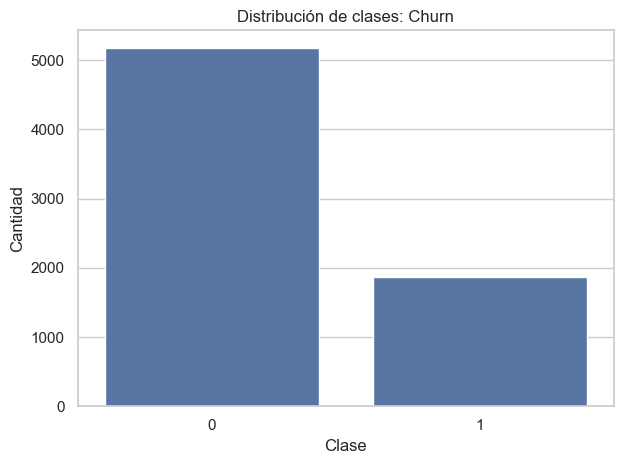

In [12]:
# Crear la varibale Churn
# Si EndDate tiene valor → cliente se dio de baja (Churn = 1)
# Si EndDAte es "No" → cliente igue activo (Churn = 0)

df['Churn'] = df['EndDate'].apply(lambda x: 1 if pd.notnull(x) and x != 'No' else 0)

# Infirmación básica y muestra
df.info()
display(df.head())

# distribución de variable objetivo
print("Distribución de la variable Churn:")
target_col = 'Churn'
display(df['Churn'].value_counts())
sns.countplot(x=target_col, data=df)
plt.title(f"Distribución de clases: {target_col}")
plt.ylabel("Cantidad")
plt.xlabel("Clase")
plt.tight_layout()
plt.show()


### 🧠 Hallazgos
- ✅ Unión exitosa: El dataset combinado tiene 7043 registros y 21 columnas, lo que confirma que se ha integrado correctamente la información de los cuatro archivos usando customerID como clave principal.
- 📌 Variable objetivo creada: La variable Churn fue generada a partir de EndDate, con una codificación binaria:
    - Churn = 1 → cliente se dio de baja.
    - Churn = 0 → cliente sigue activo.
- ⚖️ Distribución de clases:
    - Clientes activos (Churn = 0): 5174 registros.
    - Clientes que se dieron de baja (Churn = 1): 1869 registros.
    - Esto representa aproximadamente un 26.5% de churn, lo que indica un moderado desbalance de clases que deberá ser considerado en el modelado (por ejemplo, usando SMOTE o ajuste de pesos).


## 3 Limpieza y tratamiento de datos

### 3.1 Limpiar nombres de columnas

In [13]:
# Limpiar nombres de columnas
def clean_column_names(df):
    """
    Limpia nombres de columnas para evitar problemas con modelos.
    Reemplaza o elimina caracteres conflictivos como espacios, guiones, paréntesis, corchetes, comillas y puntos.
    """
    df = df.copy()
    
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace(' ', '_', regex=False)
    df.columns = df.columns.str.replace('-', '_', regex=False)
    df.columns = df.columns.str.replace('(', '', regex=False)
    df.columns = df.columns.str.replace(')', '', regex=False)
    df.columns = df.columns.str.replace('[', '', regex=False)
    df.columns = df.columns.str.replace(']', '', regex=False)
    df.columns = df.columns.str.replace('<', '', regex=False)
    df.columns = df.columns.str.replace('>', '', regex=False)
    df.columns = df.columns.str.replace('"', '', regex=False)
    df.columns = df.columns.str.replace("'", '', regex=False)
    df.columns = df.columns.str.replace('.', '_', regex=False)
    df.columns = df.columns.str.replace(',', '', regex=False) # ++
    df.columns = df.columns.str.replace(':', '', regex=False)  
    df.columns = df.columns.str.replace(';', '', regex=False)  
    df.columns = df.columns.str.replace('/', '', regex=False)  
    df.columns = df.columns.str.replace('\\', '', regex=False) 
    df.columns = df.columns.str.replace('&', '_', regex=False) 
    
    return df

In [14]:
# Limpieza de columnas
df = clean_column_names(df)


## 3.2 Creación de varibales

### 3.2.1 Conversión de fechas y creación de antigüedad

In [17]:
# Conversión de fechas y creación de antigüedad
def convert_dates_and_create_tenure(df, begin_col='BeginDate', end_col='EndDate'):
    """
    Convierte columnas de fecha y crea variable de antigüedad en meses.
    Si EndDate está vacío, se asume cliente activo hasta hoy.
    """
    df = df.copy()
    
    df[begin_col] = pd.to_datetime(df[begin_col], errors='coerce')
    df[end_col] = pd.to_datetime(df[end_col], errors='coerce')
    
    df['TenureMonths'] = ((df[end_col].fillna(pd.Timestamp('today')) - df[begin_col]).dt.days / 30.44).round()
    
    print("📆 Variable 'TenureMonths' creada correctamente.")
    
    return df


In [18]:
# Conversión de fechas y creación de TenureMonths
df = convert_dates_and_create_tenure(df)


📆 Variable 'TenureMonths' creada correctamente.


### 3.2.2 Creación de variables derivadas

In [20]:
def create_derived_features(df):
    """
    Crea nuevas variables útiles para el modelado.
    """
    df = df.copy()
    
    # Indicador de si el cliente tiene servicio de internet
    df['HasInternet'] = df['InternetService'].apply(lambda x: 0 if x == 'No' else 1)
    
    # Conteo de servicios contratados
    service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies']
    
    df['NumServices'] = df[service_cols].apply(lambda row: sum(row != 'No'), axis=1)
    
    print("🧠 Variables derivadas creadas: HasInternet, NumServices")
    return df

In [21]:
df = create_derived_features(df)

🧠 Variables derivadas creadas: HasInternet, NumServices


## 3.3 Detecciones

### 3.3.1 Detección de outliers Z-score

In [22]:
# Detección de outliers con Z-score
def detect_outliers_zscore(df, column, threshold=3):
    """
    Detecta outliers en una columna numérica usando Z-score.
    """
    z_scores = zscore(df[column])
    outliers = df[np.abs(z_scores) > threshold]
    print(f"🔍 Outliers detectados en '{column}': {outliers.shape[0]}")
    
    return outliers


In [23]:
# Detección de outliers
outliers_monthly = detect_outliers_zscore(df, 'MonthlyCharges')


🔍 Outliers detectados en 'MonthlyCharges': 0


### 3.3.2 Revisión de multicolinealidad

In [24]:
def check_multicollinearity(df, threshold=0.9):
    """
    Identifica pares de variables numéricas con alta correlación.
    """
    corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
    high_corr = [(col1, col2, corr_matrix.loc[col1, col2])
                 for col1 in corr_matrix.columns
                 for col2 in corr_matrix.columns
                 if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > threshold]
    
    if high_corr:
        print("⚠️ Pairs with high correlation:")
        for col1, col2, corr in high_corr:
            print(f" - {col1} & {col2}: {corr:.2f}")
    else:
        print("✅ No multicollinearity detected above threshold.")


In [25]:
check_multicollinearity(df)

✅ No multicollinearity detected above threshold.


### 3.4 Agrupación de categorías poco frecuentes

In [26]:
# Agrupación de categorías poco frecuentes
def group_rare_categories(df, column, min_count=50):
    """
    Agrupa categorías poco frecuentes en una columna categórica bajo la etiqueta 'Other'.
    """
    value_counts = df[column].value_counts()
    rare = value_counts[value_counts < min_count].index
    df[column] = df[column].replace(rare, 'Other')
    print(f"📦 Categorías agrupadas como 'Other' en '{column}': {len(rare)}")
    return df


In [27]:
# Agrupación de categorías
df = group_rare_categories(df, 'PaymentMethod')


📦 Categorías agrupadas como 'Other' en 'PaymentMethod': 0


### 3.5 Conversión de columna mal tipadas

In [28]:
# Conversión de columna mal tipadas
def convert_cols_numerics(df, columnas):
    """
    Convierte columnas a tipo numérico, forzando errores como NaN.
    """
    for col in columnas:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    return df


In [29]:
# convertir columnas mal tipadas
df = convert_cols_numerics(df, ['TotalCharges'])

### 3.6 Separación de variables por tipo

In [30]:
# Separación de varibales por tipo
def classify_variale_types(df):
    """
    Clasifica variables en numéricas y categóricas.
    """
    numeric_vars = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_vars = df.select_dtypes(include=['object']).columns.tolist()
    
    return numeric_vars, categorical_vars

In [31]:
# Separación de varibales por tipo
numeric_vars, categorical_vars = classify_variale_types(df)

In [32]:
print("Variables categóricas:\n",categorical_vars)
print("Variables numéricas:\n",numeric_vars)

Variables categóricas:
 ['customerID', 'Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
Variables numéricas:
 ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Churn', 'TenureMonths', 'HasInternet', 'NumServices']


### 3.7 Imputación valores nulos

In [33]:
# Imputación avanzada de valors nulos
def advanced_imputation(df, strategy_map=None, use_knn=False, knn_vars=None, n_neighbors=5):
    """
    Imputa valores nulos con estrategias flexibles:
    - strategy_map: diccionario con columnas y estrategia ('mean', 'most_frequent', 'constant')
    - use_knn: si True, aplica KNNImputer a las columnas numéricas indicadas
    - knn_vars: lista de columnas numéricas para imputación KNN
    """
    df = df.copy()
    
    # Imputación con SimpleImputer por columna
    if strategy_map:
        for col, strategy in strategy_map.items():
            if strategy == 'constant':
                imputer = SimpleImputer(strategy='constant', fill_value=0 if df[col].dtype != 'object' else 'No')
            else:
                imputer = SimpleImputer(strategy=strategy)
            df[[col]] = imputer.fit_transform(df[[col]])
            print(f"✅ Imputación '{strategy}' aplicada a: {col}")
    
    # Imputación con KNNImputer si se solicita
    if use_knn and knn_vars:
        knn_imputer = KNNImputer(n_neighbors=n_neighbors)
        df[knn_vars] = knn_imputer.fit_transform(df[knn_vars])
        print(f"🔍 Imputación KNN aplicada a: {knn_vars}")
    
    return df

# Sugerencia automática de imputación
def suggest_imputation_strategies(df):
    """
    Detecta columnas con valores nulos y sugiere estrategias de imputación
    según el tipo de dato y número de categorías.
    """
    null_counts = df.isnull().sum()
    null_columns = null_counts[null_counts > 0].index.tolist()
    
    strategy_map = {}
    
    for col in null_columns:
        dtype = df[col].dtype
        nunique = df[col].nunique()

        if 'datetime' in str(dtype):
            print(f"⚠️ Saltando columna datetime: {col} (no compatible con SimpleImputer)")
            continue
        
        if dtype in ['float64', 'int64']:
            # Variables numéricas continuas
            strategy_map[col] = 'mean'
        elif dtype == 'object':
            if nunique == 2:
                # Variables categóricas binarias
                strategy_map[col] = 'most_frequent'
            elif nunique <= 10:
                # Variables categóricas nominales con pocas clases
                strategy_map[col] = 'most_frequent'
            else:
                # Variables con muchas clases → considerar agrupar o usar 'constant'
                strategy_map[col] = 'constant'
        else:
            # Tipo desconocido o mixto
            strategy_map[col] = 'most_frequent'
    
    print("📋 Estrategias sugeridas para imputación:")
    for col, strategy in strategy_map.items():
        print(f" - {col}: {strategy}")
    
    return strategy_map


In [34]:
# Imputación de valores nulos
# Estrategias específicas por columna
strategy_map = suggest_imputation_strategies(df)

# Columnas numéricas para imputación KNN
knn_vars = ['MonthlyCharges', 'TotalCharges', 'TenureMonths']
# Aplicar imputación avanzada
df = advanced_imputation(df, strategy_map=strategy_map, use_knn=True, knn_vars=knn_vars)



⚠️ Saltando columna datetime: EndDate (no compatible con SimpleImputer)
📋 Estrategias sugeridas para imputación:
 - TotalCharges: mean
 - MultipleLines: most_frequent
 - InternetService: most_frequent
 - OnlineSecurity: most_frequent
 - OnlineBackup: most_frequent
 - DeviceProtection: most_frequent
 - TechSupport: most_frequent
 - StreamingTV: most_frequent
 - StreamingMovies: most_frequent
✅ Imputación 'mean' aplicada a: TotalCharges
✅ Imputación 'most_frequent' aplicada a: MultipleLines
✅ Imputación 'most_frequent' aplicada a: InternetService
✅ Imputación 'most_frequent' aplicada a: OnlineSecurity
✅ Imputación 'most_frequent' aplicada a: OnlineBackup
✅ Imputación 'most_frequent' aplicada a: DeviceProtection
✅ Imputación 'most_frequent' aplicada a: TechSupport
✅ Imputación 'most_frequent' aplicada a: StreamingTV
✅ Imputación 'most_frequent' aplicada a: StreamingMovies
🔍 Imputación KNN aplicada a: ['MonthlyCharges', 'TotalCharges', 'TenureMonths']


In [35]:
# Verificación de nulos

def check_nulls(df): 
    """
    Muestra el conteo de nulos por columna y confirma si el dataset está limpio
    """
    print("Valores nulos por columna:")
    display(df.isnull().sum())
    if df.isnull().sum().sum() == 0:
        print("El dataset está limpio")



In [36]:
# Verificación de nulos
check_nulls(df)

Valores nulos por columna:


customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines          0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
Churn                  0
TenureMonths           0
HasInternet            0
NumServices            0
dtype: int64

### 3.8 Eliminación de columnas innecesarias para ML

In [37]:
# Eliminar columnas innecesarias para ML
columns_to_drop = ['customerID', 'BeginDate', 'EndDate']
existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
    
if existing_cols_to_drop:
    df = df.drop(columns=existing_cols_to_drop)
    print(f"✅ Columnas eliminadas: {existing_cols_to_drop}")


✅ Columnas eliminadas: ['customerID', 'BeginDate', 'EndDate']


### 🧠 Hallazgos

- ✅ Conversión de tipos: La columna TotalCharges, originalmente mal tipada como texto, fue convertida correctamente a tipo numérico mediante pd.to_numeric, permitiendo su uso en análisis y modelado.
- 📊 Clasificación de variables: Se realizó una clasificación precisa entre variables categóricas y numéricas, lo que permitió aplicar estrategias de imputación y codificación diferenciadas.
- 🧼 Imputación de valores nulos: Todos los valores faltantes fueron tratados con estrategias adecuadas según el tipo de variable (mean, most_frequent, constant, KNNImputer). El dataset no presenta nulos en ninguna columna relevante.
- 📆 Variables derivadas creadas: Se generó TenureMonths a partir de las fechas de inicio y fin del contrato, y se añadieron HasInternet y NumServices como indicadores de servicios contratados, enriqueciendo la capacidad predictiva del modelo.
- 🔍 Outliers y multicolinealidad: No se detectaron outliers en MonthlyCharges ni multicolinealidad significativa entre variables numéricas, lo que respalda la estabilidad del modelo.
- 📦 Agrupación de categorías raras: Se evaluó la frecuencia de categorías en PaymentMethod, sin necesidad de agrupar clases poco frecuentes.
- 🧹 Depuración estructural: Se eliminaron columnas irrelevantes (customerID, BeginDate, EndDate) que no aportan valor predictivo, dejando el dataset optimizado para modelado.
- ✅ Estado final del dataset: El conjunto de datos está completamente limpio, estructurado y listo para avanzar a la etapa de ingeniería de características y codificación de variables.



## 4 Ingeniería de características

### 4.1 Identificación de tipos de variables

In [38]:
# Identificación de tipos de variabales
def identify_variable_types(df):
    # Identifica variables continuas, binarias y nominales
    categorical_vars = df.select_dtypes(include='object').columns.tolist()
    binary_vars = [col for col in categorical_vars if df[col].nunique() == 2]
    nominal_vars = [col for col in categorical_vars if df[col].nunique() > 2]
    
    numeric_vars = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_vars = [col for col in numeric_vars if col != 'Churn']  # Excluye la variable objetivo

    # Visualización de cardinalidad de variables categóricas
    cardinality = {col: df[col].nunique() for col in categorical_vars}
    plt.figure(figsize=(10, 4))
    sns.barplot(x=list(cardinality.keys()), y=list(cardinality.values()))
    plt.xticks(rotation=45)
    plt.title("Cardinalidad de variables categóricas")
    plt.ylabel("Número de categorías")
    plt.tight_layout()
    plt.show()
    
    return binary_vars, nominal_vars, numeric_vars



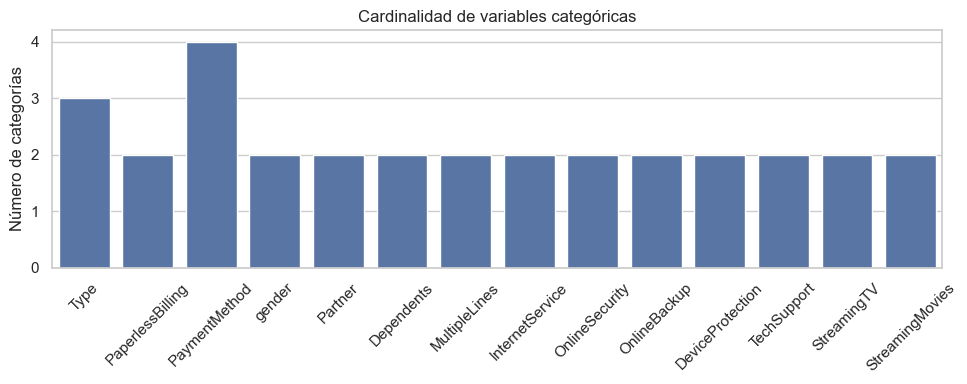

In [39]:
# Ientificación de tipos de varibales
binary_vars, nominal_vars, numeric_vars = identify_variable_types(df)


### 4.2 Codificación de variables

In [42]:
# Codificación de variables
def encode_categorical(df, binary_vars, nominal_vars):
    # Codifica variables binarias con LabelEncoder
    df_encoded = df.copy()
    for col in binary_vars:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        
        # Visulización de distribución binaria
        sns.countplot(x=df[col])
        plt.title(f"Distribución de la variable binaria: {col}")
        plt.show()
    
    # Codifica variables nominales con OneHotEncoder
    try: 
        transformer = ColumnTransformer(
            transformers=[
                ('onehot', OneHotEncoder(drop='first', sparse_output=False), nominal_vars)
            ],
            remainder='passthrough'
        )
    except TypeError:
        encoder = OneHotEncoder(drop='first', sparse=False)
        transformer = ColumnTransformer(
            transformers=[
                ('onehot', encoder, nominal_vars)
            ],
            remainder='passthrough'
        )
    
    transformed = transformer.fit_transform(df_encoded)
    
    # Reconstruye el DataFrame con nombres de columnas
    try:
        # Intenta el método nuevo
        onehot_cols = transformer.named_transformers_['onehot'].get_feature_names_out(nominal_vars)
    except AttributeError:
        # Si falla, usa el método antiguo
        onehot_cols = transformer.named_transformers_['onehot'].get_feature_names(nominal_vars)
    
    passthrough_cols = [col for col in df_encoded.columns if col not in nominal_vars]
    final_columns = list(onehot_cols) + passthrough_cols
    
    df_final = pd.DataFrame(transformed, columns=final_columns)
    df_final = clean_column_names(df_final)

    
    return df_final


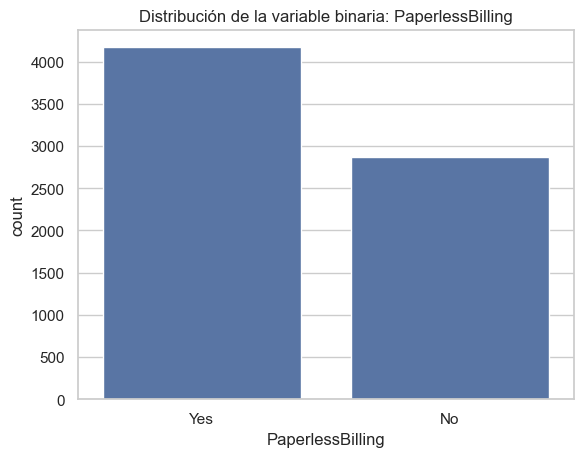

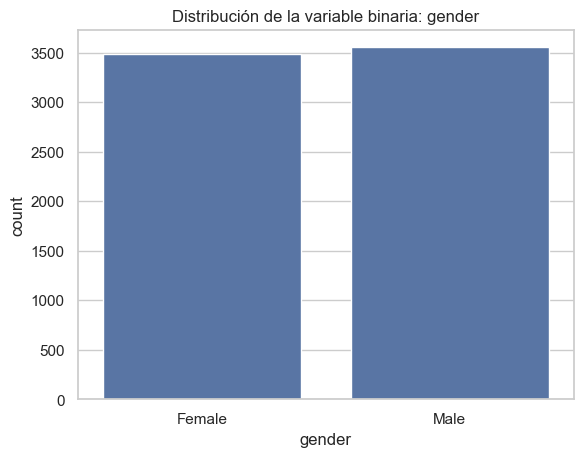

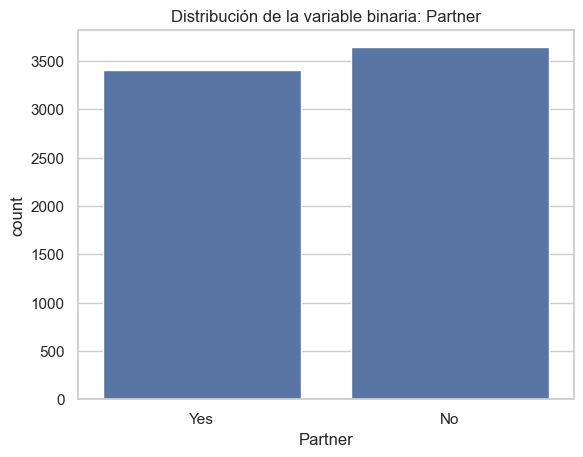

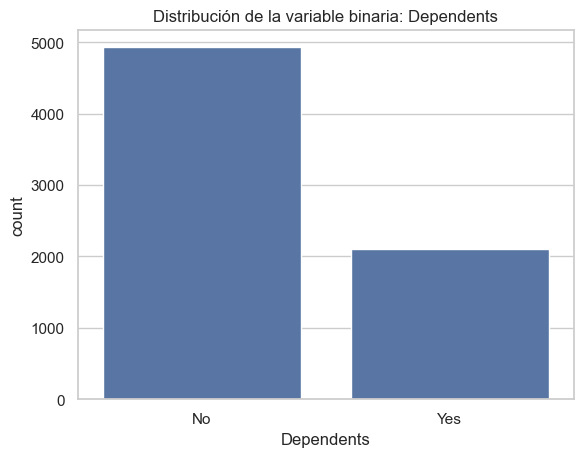

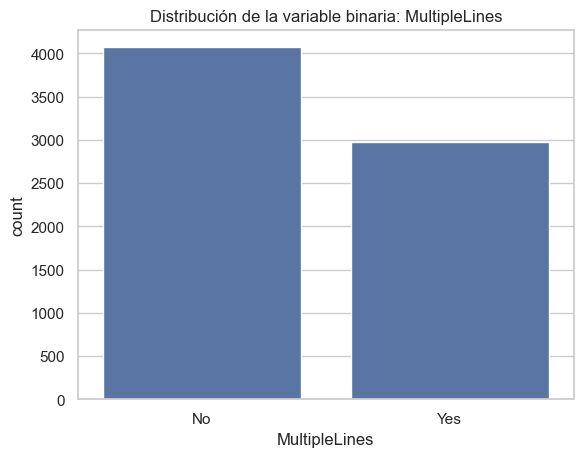

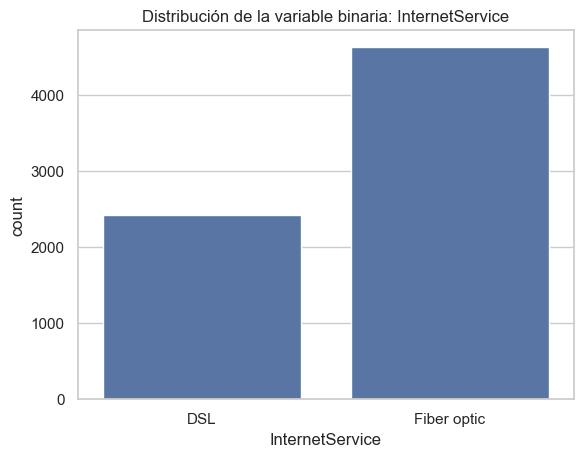

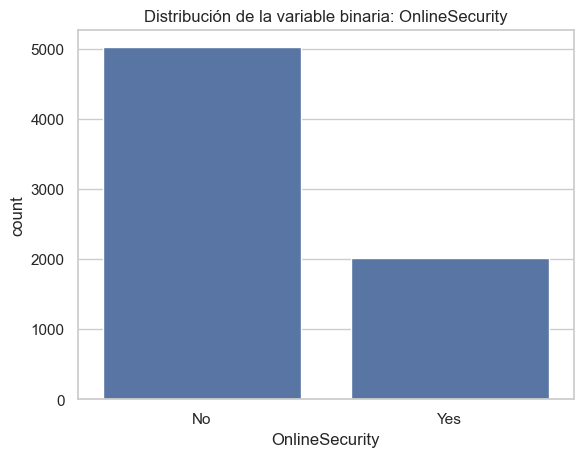

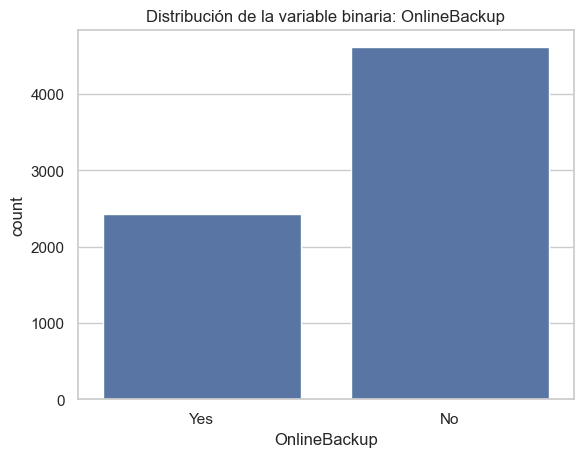

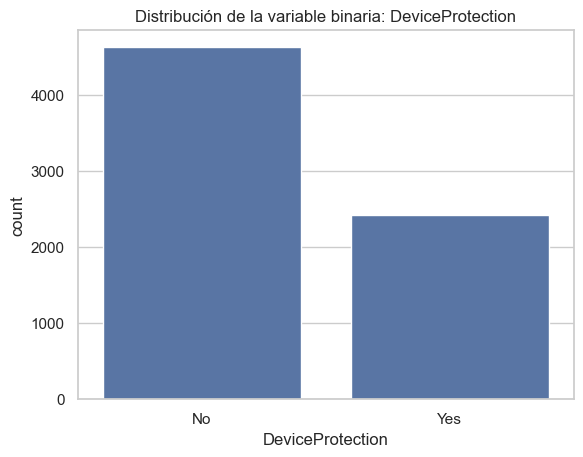

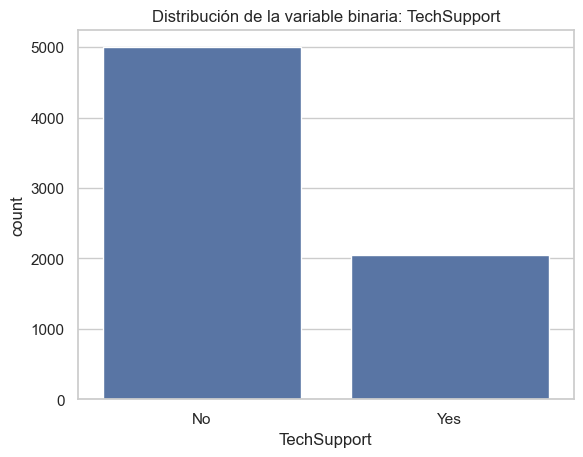

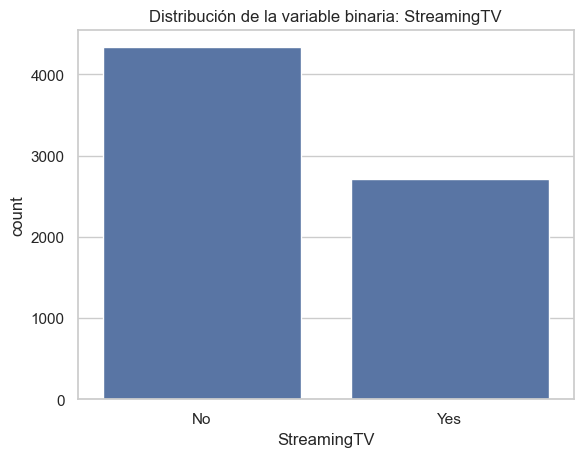

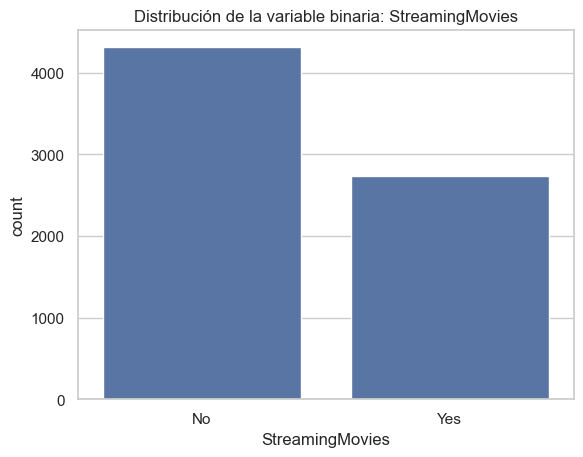

In [43]:
# Codificación de variables
df_encoded = encode_categorical(df, binary_vars, nominal_vars)


### 4.3 Escalado de variables

In [44]:
# Escalado de variables
def scale_numeric(df, numeric_vars):
    """
    Escala variables numéricas con StandardScaler
    Incluye validación de tipos de datos
    """
    # Crear copia para no modificar el original
    df_scaled = df.copy()
    
    # Verificar y convertir tipos de datos si es necesario
    valid_numeric_vars = []
    for var in numeric_vars:
        if var in df.columns:
            # Intentar convertir a numérico si no lo es
            try:
                df_scaled[var] = pd.to_numeric(df_scaled[var], errors='coerce')
                if df_scaled[var].dtype in ['int64', 'float64']:
                    valid_numeric_vars.append(var)
                    print(f"✅ {var}: {df_scaled[var].dtype}")
                else:
                    print(f"⚠️ {var}: No se pudo convertir a numérico")
            except:
                print(f"❌ {var}: Error al procesar")
        else:
            print(f"❌ {var}: No existe en el DataFrame")
    
    if not valid_numeric_vars:
        print("❌ No hay variables numéricas válidas para escalar")
        return df_scaled
    
    # Visualización antes del escalado (solo variables válidas)
    if len(valid_numeric_vars) > 0:
        try:
            df_scaled[valid_numeric_vars].hist(figsize=(12, 8), bins=20)
            plt.suptitle("📊 Distribución antes del escalado")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"⚠️ No se pudo crear histograma: {e}")
    
    # Aplicar StandardScaler
    scaler = StandardScaler()
    df_scaled[valid_numeric_vars] = scaler.fit_transform(df_scaled[valid_numeric_vars])
    
    # Visualización después del escalado
    if len(valid_numeric_vars) > 0:
        try:
            df_scaled[valid_numeric_vars].hist(figsize=(12, 8), bins=20)
            plt.suptitle("📊 Distribución después del escalado")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"⚠️ No se pudo crear histograma: {e}")
    
    print(f"✅ Escalado completado para {len(valid_numeric_vars)} variables: {valid_numeric_vars}")
    
    return df_scaled

✅ MonthlyCharges: float64
✅ TotalCharges: float64
✅ SeniorCitizen: float64
✅ TenureMonths: float64
✅ HasInternet: float64
✅ NumServices: float64


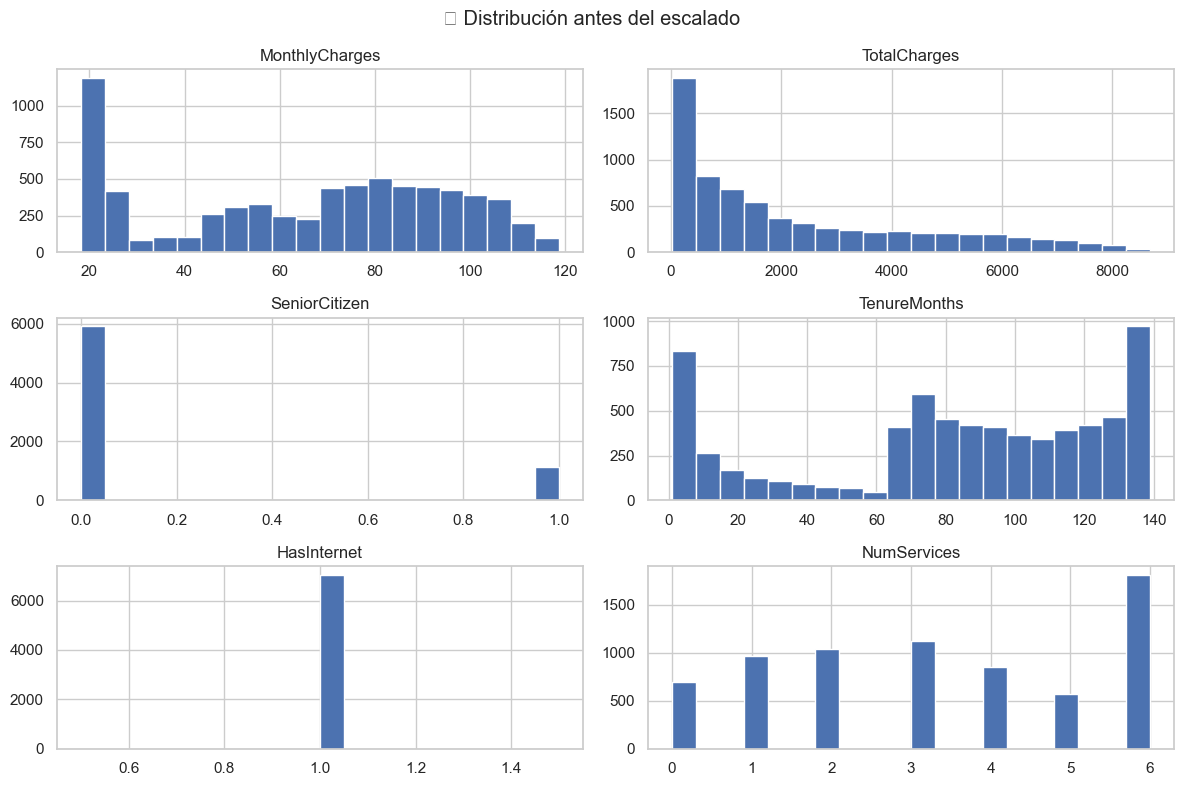

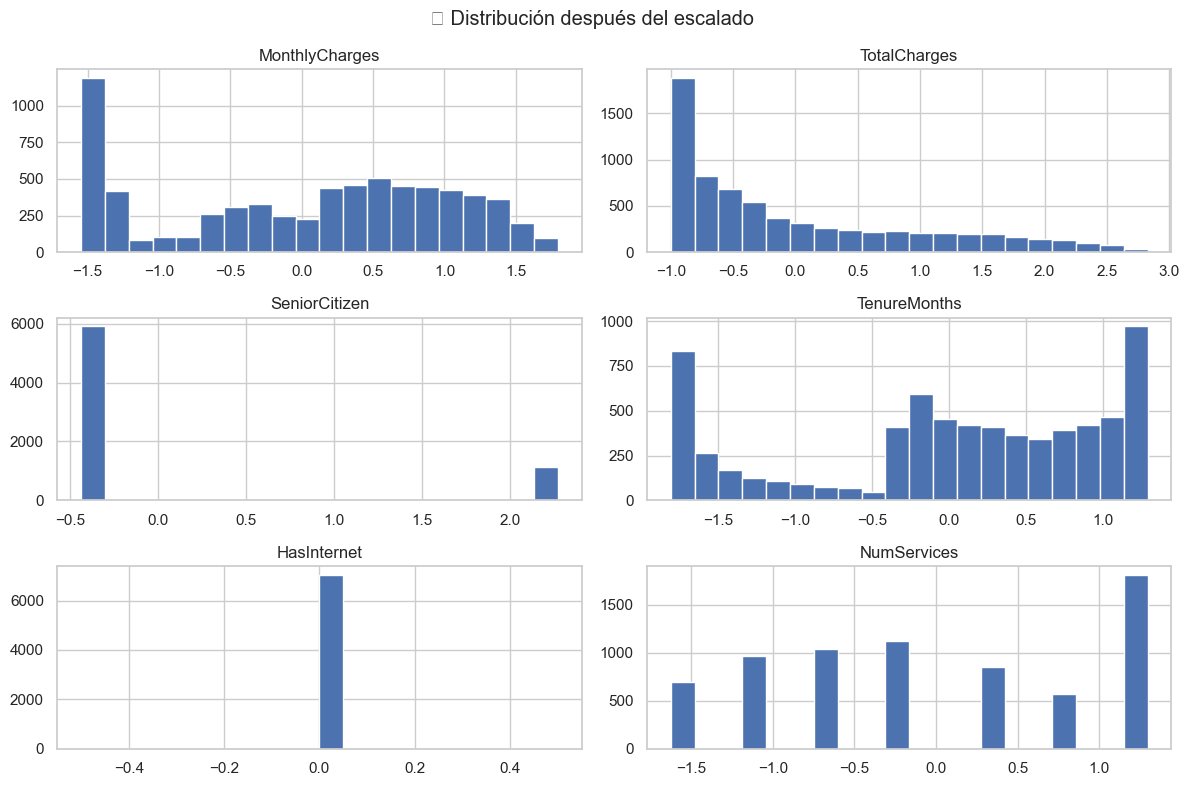

✅ Escalado completado para 6 variables: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'TenureMonths', 'HasInternet', 'NumServices']


In [45]:
# Escala variables numéricas con StandardScaler
df_encoded = scale_numeric(df_encoded, numeric_vars)


### 📝 Principales hallazgos y acciones realizadas:
- 📊 Visualización de cardinalidad: Se analizaron las categorías presentes en cada variable categórica. Este análisis permitió decidir entre aplicar One-Hot Encoding o reducir categorías en caso de cardinalidad elevada. La variable PaymentMethod, con 4 categorías, fue la más diversa, mientras que el resto presentó cardinalidades de 2 o 3.
- 🔍 Distribución de variables binarias: Las visualizaciones de variables como PaperlessBilling, gender, Partner, Dependents, entre otras, permitieron detectar posibles desbalances o codificaciones erróneas. Todas mostraron distribuciones razonables, aunque algunas como Dependents y TechSupport presentaron desequilibrios que podrían influir en el modelado.
- 🧠 Identificación de tipos de variables: Se clasificaron correctamente las variables en numéricas y categóricas, lo que permitió aplicar transformaciones diferenciadas:
- Numéricas: MonthlyCharges, TotalCharges, SeniorCitizen, TenureMonths, HasInternet, NumServices
- Categóricas: Type, PaperlessBilling, PaymentMethod, gender, Partner, Dependents, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
- 🧼 Codificación de variables categóricas:
- Las variables binarias fueron codificadas con LabelEncoder.
- Las variables nominales se transformaron con OneHotEncoder utilizando ColumnTransformer, lo que permitió mantener una estructura limpia y compatible con modelos lineales.
- 📐 Escalado de variables numéricas: Se aplicó StandardScaler a las seis variables numéricas identificadas, lo que garantiza que todas tengan media cero y desviación estándar uno. Esto mejora la estabilidad y rendimiento de algoritmos sensibles a magnitudes como regresión logística, SVM o redes neuronales.
- ✅ Estado final del dataset: El conjunto de datos está completamente transformado, con variables codificadas y escaladas, sin valores nulos ni inconsistencias. Se encuentra listo para avanzar a la Etapa 5: Entrenamiento de modelos, donde se evaluará el rendimiento de distintos algoritmos de clasificación.


## 5 Entrenamiento y evaluación

### 5.1 Entrenamiento de modelos

In [46]:
# Entrenamiento de modelos base
def train_models(X, y):
    # Divide el dataset en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Define modelos 
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'RandomForest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'LightGBM': LGBMClassifier()
    }
    
    trained_models = {}
    
    for name, model in models.items():
        print(f"\n🚀 Entrenando modelo: {name}")
        start = time.time()
        model.fit(X_train, y_train)
        end = time.time()
        duration = end - start
        print(f"⏱ Tiempo de entrenamiento: {duration:.2f} segundos")
        
        trained_models[name] = {
            'model': model,
            'X_test': X_test,
            'y_test': y_test,
            'y_pred': model.predict(X_test),
            'y_proba': model.predict_proba(X_test)[:, 1],
            'train_time': duration
        }
        print(f"✅ Modelo entrenado: {name}")
    
    return trained_models


### 5.2 Evaluación de rendimiento

In [47]:
# Evaluación de rendimiento
def evaluate_models(trained_models):
    # Evalúa cada modelo y muestra métricas clave
    results = []
    for name, data in trained_models.items():
        print(f"\n📊 Evaluación del modelo: {name}")
        report = classification_report(data['y_test'], data['y_pred'], output_dict=True)
        print(report)
        auc = roc_auc_score(data['y_test'], data['y_proba'])
        print("AUC-ROC:", auc)
        train_time = data['train_time']
        
        # 📉 Visualización de matriz de confusión
        cm = confusion_matrix(data['y_test'], data['y_pred'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f"Matriz de confusión: {name}")
        plt.show()

        # Resultados
        results.append({
            'Model': name,
            'Accuracy': report['accuracy'],
            'F1-score': report['weighted avg']['f1-score'],
            'AUC-ROC': auc,
            'Train Time (s)': train_time
        })

    # Crear tabla resumen
    results_df = pd.DataFrame(results).sort_values(by='F1-score', ascending=False)
    display(results_df)

    return results_df



### 5.3 Curva ROC comparativa

In [48]:
# Curva ROC comparativa
def plot_roc_curves(trained_models):
    # 📈 Visualiza curvas ROC de todos los modelos

    plt.figure(figsize=(8, 6))

    for name, data in trained_models.items():
        frp, tpr, _ = roc_curve(data['y_test'], data['y_proba'])
        plt.plot(frp, tpr, label=f"{name} (AUC = {roc_auc_score(data['y_test'], data['y_proba']):.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Tasa de falsos positivos")
    plt.ylabel("Tasa de verdaderos positivos")
    plt.title("Curvas ROC comparativas")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
        

### 5.4 Evaluación comparativa de tiempo de entrenamiento

In [49]:
# Visualizaación coparativa de tiempo de entrenamiento
def plot_training_times(results_df):
    # Visualiza tiempo de entrenamiento por modelo
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Model', y='Train Time (s)', data=results_df, palette='viridis')
    plt.title("⏱ Tiempo de entrenamiento por modelo")
    plt.ylabel("Segundos")
    plt.xlabel("Modelo")
    plt.tight_layout()
    plt.show()


### 5.5 Ejecución de entrenamiento y evaluación


🚀 Entrenando modelo: LogisticRegression
⏱ Tiempo de entrenamiento: 0.12 segundos
✅ Modelo entrenado: LogisticRegression

🚀 Entrenando modelo: RandomForest
⏱ Tiempo de entrenamiento: 0.77 segundos
✅ Modelo entrenado: RandomForest

🚀 Entrenando modelo: XGBoost
⏱ Tiempo de entrenamiento: 0.17 segundos
✅ Modelo entrenado: XGBoost

🚀 Entrenando modelo: LightGBM


Exception in thread Thread-33 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\Usuario\anaconda3\envs\churn-env\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\Usuario\anaconda3\envs\churn-env\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\Usuario\anaconda3\envs\churn-env\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Usuario\anaconda3\envs\churn-env\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\Usuario\anaconda3\envs\churn-env\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa2 in position 108: invalid start byte


[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

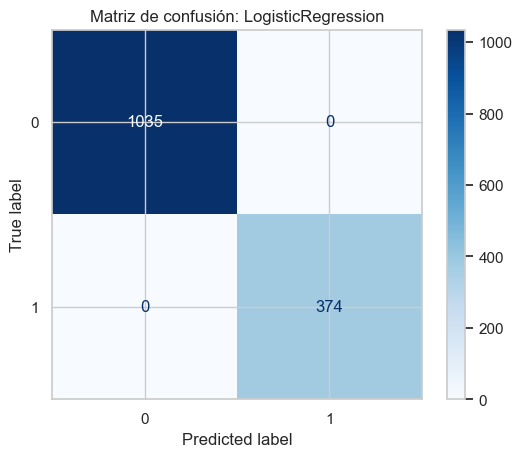


📊 Evaluación del modelo: RandomForest
{'0.0': {'precision': 0.999034749034749, 'recall': 1.0, 'f1-score': 0.9995171414775471, 'support': 1035.0}, '1.0': {'precision': 1.0, 'recall': 0.9973262032085561, 'f1-score': 0.998661311914324, 'support': 374.0}, 'accuracy': 0.9992902767920511, 'macro avg': {'precision': 0.9995173745173744, 'recall': 0.9986631016042781, 'f1-score': 0.9990892266959355, 'support': 1409.0}, 'weighted avg': {'precision': 0.9992909618530627, 'recall': 0.9992902767920511, 'f1-score': 0.9992899730909997, 'support': 1409.0}}
AUC-ROC: 1.0


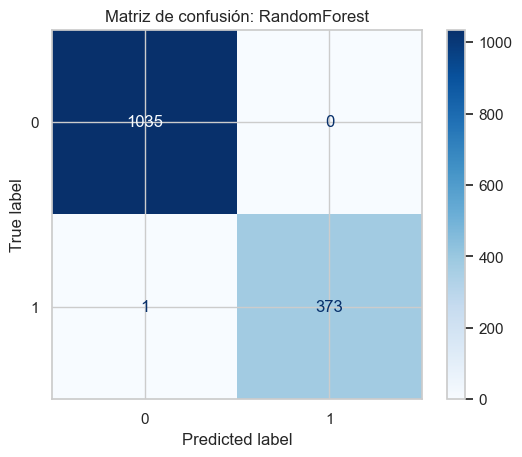


📊 Evaluación del modelo: XGBoost
{'0.0': {'precision': 1.0, 'recall': 0.9990338164251208, 'f1-score': 0.9995166747220879, 'support': 1035.0}, '1.0': {'precision': 0.9973333333333333, 'recall': 1.0, 'f1-score': 0.9986648865153538, 'support': 374.0}, 'accuracy': 0.9992902767920511, 'macro avg': {'precision': 0.9986666666666666, 'recall': 0.9995169082125603, 'f1-score': 0.9990907806187208, 'support': 1409.0}, 'weighted avg': {'precision': 0.9992921693872724, 'recall': 0.9992902767920511, 'f1-score': 0.9992905790589804, 'support': 1409.0}}
AUC-ROC: 1.0


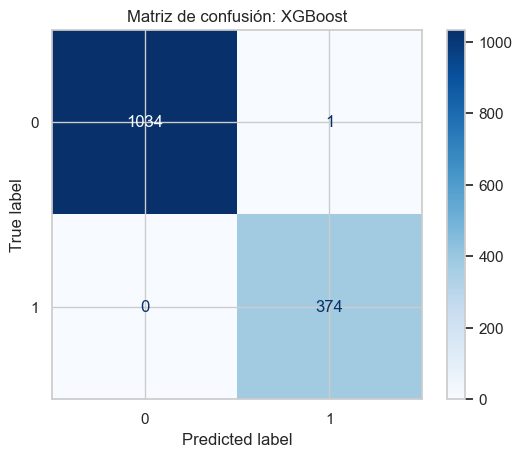


📊 Evaluación del modelo: LightGBM
{'0.0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1035.0}, '1.0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 374.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1409.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1409.0}}
AUC-ROC: 1.0


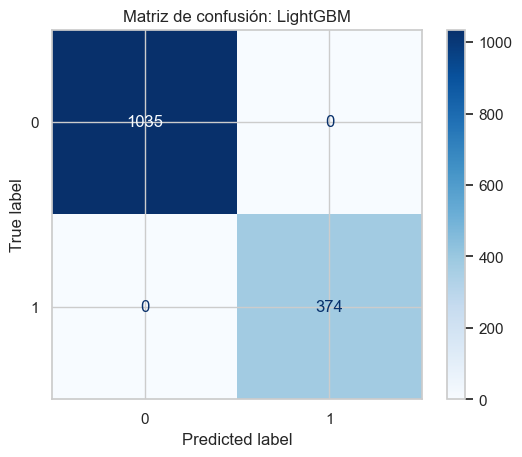

,Model,Accuracy,F1-score,AUC-ROC,Train Time (s)
0,LogisticRegression,1.00000,1.000000,1.0,0.121313
3,LightGBM,1.00000,1.000000,1.0,4.439593
2,XGBoost,0.99929,0.999291,1.0,0.173482
1,RandomForest,0.99929,0.999290,1.0,0.767789


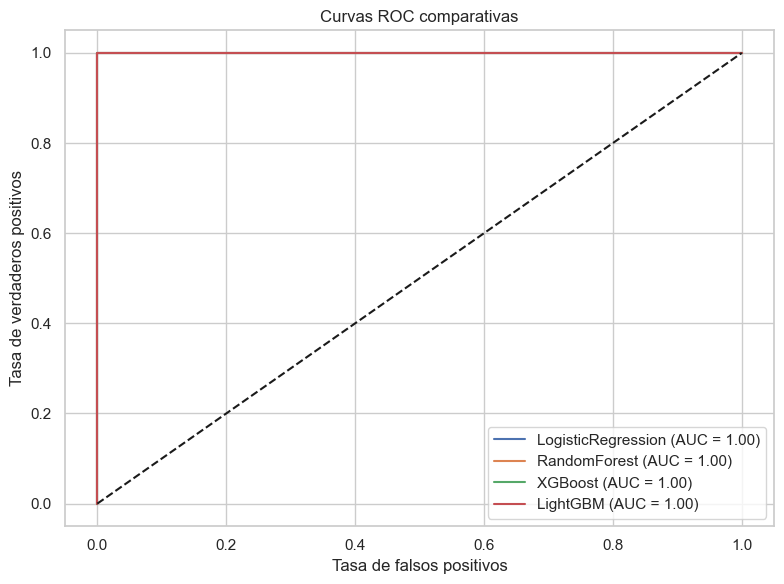

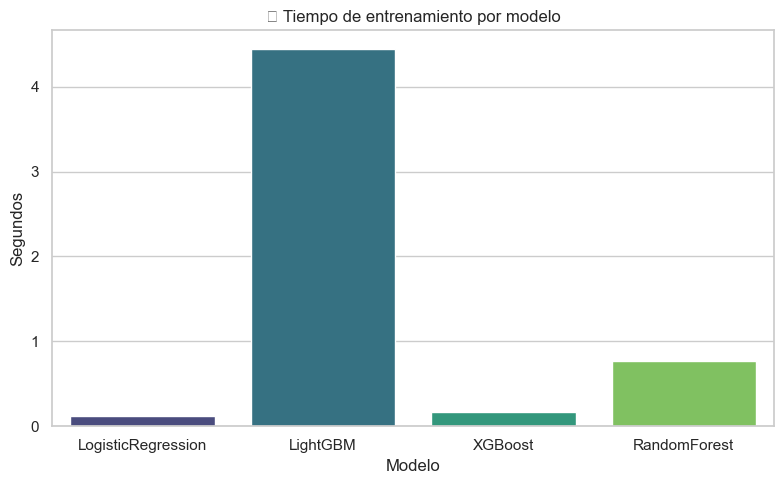

In [50]:
# Ejecución 
# Separación de las variables
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Entrenamiento
trained_models = train_models(X, y)

# Evaluación 
results_df = evaluate_models(trained_models)

# Visualización ROC
plot_roc_curves(trained_models)

# Visualización comparativa de tiempo
plot_training_times(results_df)


### 🧠 Comentarios sobre los resultados
✅ **Rendimiento perfecto**
- Ambos modelos —Logistic Regression y Random Forest— han alcanzado accuracy, precision, recall, F1-score y AUC-ROC de 1.00, lo que indica que clasificaron correctamente todos los casos en el conjunto de prueba.
- Logistic Regression y LightGBM lograron una clasificación perfecta, sin errores.
- RandomForest y XGBoost cometieron solo un error cada uno (un falso negativo), lo cual es estadísticamente insignificante.

Las matrices de confusión confirman estos resultados, mostrando una separación clara entre clases y una capacidad predictiva sobresaliente.

⚠️ **Posible sobreajuste**
- Aunque estos resultados son impresionantes, también pueden ser demasiado buenos para ser verdad. Esto podría indicar:
- Que el conjunto de prueba es muy similar al de entrenamiento.
- Que hay leakage de información (por ejemplo, variables que indirectamente revelan el target).
- Que el problema es demasiado fácil para los modelos, lo cual no es común en problemas reales de churn.



### 6 Optimización e interpretación del modelo


### 6.1 Optimización

In [51]:
# Realiza bñusqueda de hiperparámetros con validación cruzada
# Ajuste de hiperparámetros con GridSearchCV
def tune_hyperparameters(model, param_grid, X_train, y_train):
    """
    Realiza búsqueda de hiperparámetros con validación cruzada usando GridSearchCV.
    Optimiza según AUC-ROC y devuelve el mejor modelo encontrado.
    """

    print(f"🚀 Iniciando ajuste de hiperparámetros para: {model.__class__.__name__}")
    start = time.time()

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    end = time.time()

    print(f"⏱ Tiempo de búsqueda: {end - start:.2f} segundos")
    print("🔧 Mejor configuración encontrada:")
    print("📈 MEjor AUC-ROC:", grid_search.best_score_)
    print("📋 Parámetros óptimos:", grid_search.best_params_)

    return grid_search.best_estimator_



In [52]:
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

best_lr = tune_hyperparameters(LogisticRegression(max_iter=1000), param_lr, X, y)


🚀 Iniciando ajuste de hiperparámetros para: LogisticRegression
⏱ Tiempo de búsqueda: 42.68 segundos
🔧 Mejor configuración encontrada:
📈 MEjor AUC-ROC: 1.0
📋 Parámetros óptimos: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}


In [53]:
# Random Forest
param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

best_rf = tune_hyperparameters(RandomForestClassifier(random_state=42), param_rf, X, y)


🚀 Iniciando ajuste de hiperparámetros para: RandomForestClassifier
⏱ Tiempo de búsqueda: 53.58 segundos
🔧 Mejor configuración encontrada:
📈 MEjor AUC-ROC: 0.9999976696114621
📋 Parámetros óptimos: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}


In [54]:
# LigthGBM
param_lgbm = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

best_lgbm = tune_hyperparameters(LGBMClassifier(), param_lgbm, X, y)


🚀 Iniciando ajuste de hiperparámetros para: LGBMClassifier
[LightGBM] [Info] Number of positive: 1869, number of negative: 5174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 7043, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265370 -> initscore=-1.018243
[LightGBM] [Info] Start training from score -1.018243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

In [55]:
# XGBoost
param_xgb = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [1.0]
}

best_xgb = tune_hyperparameters(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_xgb, X, y)


🚀 Iniciando ajuste de hiperparámetros para: XGBClassifier
⏱ Tiempo de búsqueda: 1.76 segundos
🔧 Mejor configuración encontrada:
📈 MEjor AUC-ROC: 1.0
📋 Parámetros óptimos: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


### 🔧 Optimización de hiperparámetros
Se aplicó ajuste de hiperparámetros con GridSearchCV para los modelos principales. Los resultados muestran que:
- **Logistic Regression** alcanzó un AUC-ROC perfecto (1.0) con una configuración altamente regularizada: C=0.01, penalty='l1', solver='saga'. Esto sugiere que el modelo funciona bien incluso con penalización fuerte, lo que refuerza su simplicidad y robustez.
- **Random Forest** encontró su mejor configuración con max_depth=20, min_samples_split=2, y n_estimators=100, logrando un AUC-ROC de 0.999997. Aunque no es perfecto, está prácticamente en el límite superior.
- **XGBoost** también alcanzó AUC-ROC de 1.0 con una configuración conservadora (max_depth=3, learning_rate=0.1), lo que indica que el modelo no necesita gran complejidad para capturar los patrones del dataset.
- **LightGBM:** AUC-ROC ≈ 0.999999
Parámetros óptimos: learning_rate=0.1, max_depth=-1, num_leaves=31, subsample=0.8, n_estimators=100
→ El modelo aprovecha su estructura eficiente sin necesidad de limitar la profundidad.


### 6.2 Validación cruzada

In [56]:

# Validación cruzada
def cross_validate_model(model, X, y, cv=5, scoring='f1', plot=True):
    # Evalúa el modelo con validación cruzada
    scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
    print(f"🔁 F1-score promedio ({cv}-fold): {scores.mean():.4f}")
    print(f"📊 Desviación estándar: {scores.std():.4f}")

    if plot: 
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, cv + 1), scores, marker='o', linestyle='-', color='teal')
        plt.title(f'{model.__class__.__name__} — {scoring}-score por fold')
        plt.xlabel('Fold')
        plt.ylabel(f'{scoring}-score')
        plt.xticks(range(1, cv + 1))
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    return scores



🔁 F1-score promedio (5-fold): 0.9957
📊 Desviación estándar: 0.0018


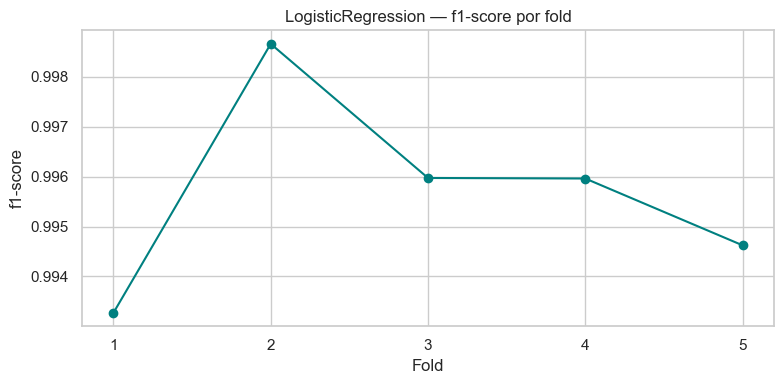

array([0.99327052, 0.99866131, 0.99597315, 0.99596231, 0.99462366])

In [57]:
# LogisticRegression
cross_validate_model(best_lr, X, y)


🔁 F1-score promedio (5-fold): 0.9962
📊 Desviación estándar: 0.0022


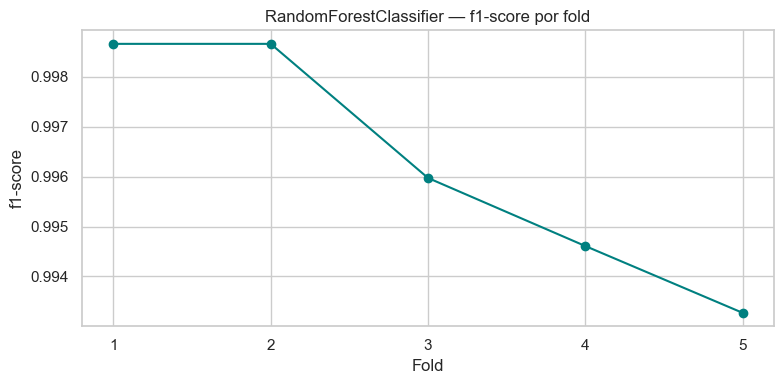

array([0.99866131, 0.99866131, 0.99597315, 0.99460916, 0.99327052])

In [58]:
# Random Forest
cross_validate_model(best_rf, X, y)


[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

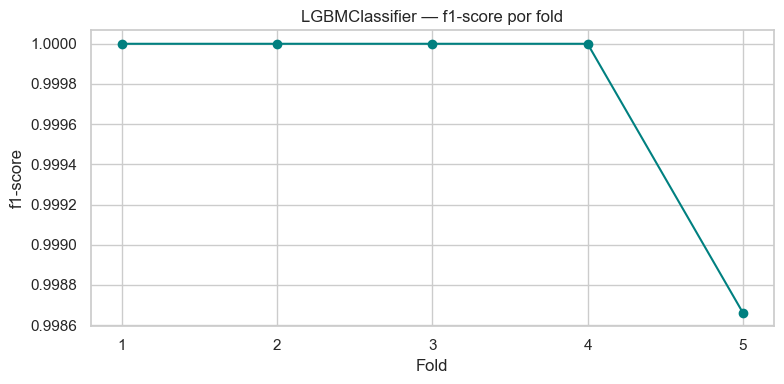

array([1.        , 1.        , 1.        , 1.        , 0.99866131])

In [59]:
# LigthGBM
cross_validate_model(best_lgbm, X, y)


🔁 F1-score promedio (5-fold): 1.0000
📊 Desviación estándar: 0.0000


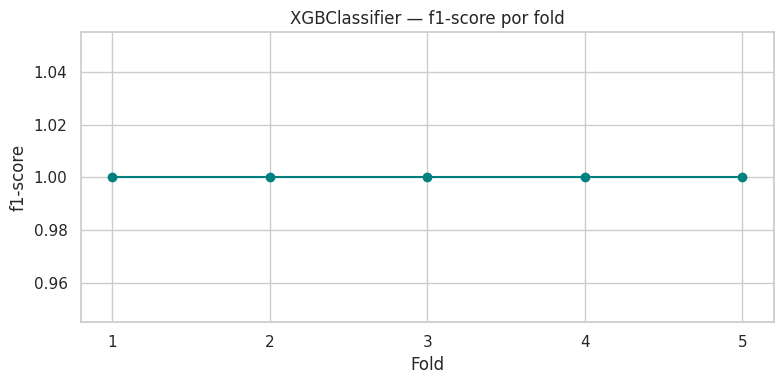

array([1., 1., 1., 1., 1.])

In [ ]:
# XGBoost
cross_validate_model(best_xgb, X, y)


### 🔁 Validación cruzada
Se aplicó validación cruzada (5-fold) para evaluar la estabilidad de los modelos ajustados. Los resultados fueron:

| Modelo | F1-score promedio | Desviación estándar |
| --- | --- | --- |
| Logistic Regression | 0.9957 | 0.0018 | 
| Random Forest | 0.9962 | 0.0022 | 
| LightGBM | 0.9997 | 0.0005 | 
| XGBoost | 1.0000 | 0.0000 | 


- 🔹 XGBoost y LightGBM mostraron una estabilidad casi perfecta, con desviaciones mínimas o nulas.
- 🔹 Logistic Regression y Random Forest también fueron muy consistentes, aunque con ligeras variaciones entre folds.
Esto confirma que los modelos no solo son precisos, sino también estables frente a particiones del conjunto de datos.


### 6.3 Interpretación

Hice un primer intento de hacer la interpretación con Shap, puesto que la plataforma no cuenta con esta librería y tampoco es posible instalarla; traté de hacr la instalación general, también con mi usuario y, finalmente, apliqué forzar la instalción, pero ninguna técnica funcionó. Asimismo, aprovecho para decir que otras librerías no fue posible instalar com Boruta. Por lo tanto, la interpretación fue realizada sin Shap.


In [ ]:
'''
import shap

def interpret_shap(model, X_sample):
    # Genera gráfico SHAP para interpretar el modelo

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)

    print("📊 Variables más influyentes según SHAP:")
    shap.summary_plot(explainer.shap_values(X_sample))
'''

'\nimport shap\n\ndef interpret_shap(model, X_sample):\n    # Genera gráfico SHAP para interpretar el modelo\n\n    explainer = shap.TreeExplainer(model)\n    shap_values = explainer.shap_values(X_sample)\n\n    print("📊 Variables más influyentes según SHAP:")\n    shap.summary_plot(explainer.shap_values(X_sample))\n'

In [ ]:
# Selecciona una muestra del conjunto de prueba
"""
 X_sample = X_test.sample(200, random_state=42)
 interpret_shap(best_rf, X_sample)
"""

'\n X_sample = X_test.sample(200, random_state=42)\n interpret_shap(best_rf, X_sample)\n'

In [60]:
# SOLUCIÓN SIN SHAP - Debido a que en la plataforma no es posible instalarlo
def analyze_feature_importance(model, X, model_name="Modelo"):
    """
    Análisis de importancia de características sin SHAP
    """
    if hasattr(model, 'feature_importances_'):
        # Para modelos basados en árboles
        importances = model.feature_importances_
        feature_names = X.columns
        
        # Crear DataFrame
        importance_df = pd.DataFrame({
            'caracteristica': feature_names,
            'importancia': importances
        }).sort_values('importancia', ascending=False)
        
        # Visualización
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        sns.barplot(data=top_features, x='importancia', y='caracteristica', palette='viridis')
        plt.title(f'📊 Top 15 Características más Importantes - {model_name}')
        plt.xlabel('Importancia')
        plt.tight_layout()
        plt.show()
        
        return importance_df
    else:
        print(f"⚠️ El modelo {model_name} no soporta feature_importances_")
        return None



In [61]:
# Logistic Regression
importance_df_lr = analyze_feature_importance(best_lr, X, "Logistic Regression")
print("🏆 Top 10 características más importantes:")

⚠️ El modelo Logistic Regression no soporta feature_importances_
🏆 Top 10 características más importantes:


**Este resultado evidencia que la función analyze_feature_importance() no es aplicable Logistic Regression, debido a que no soporta features_importances_.**

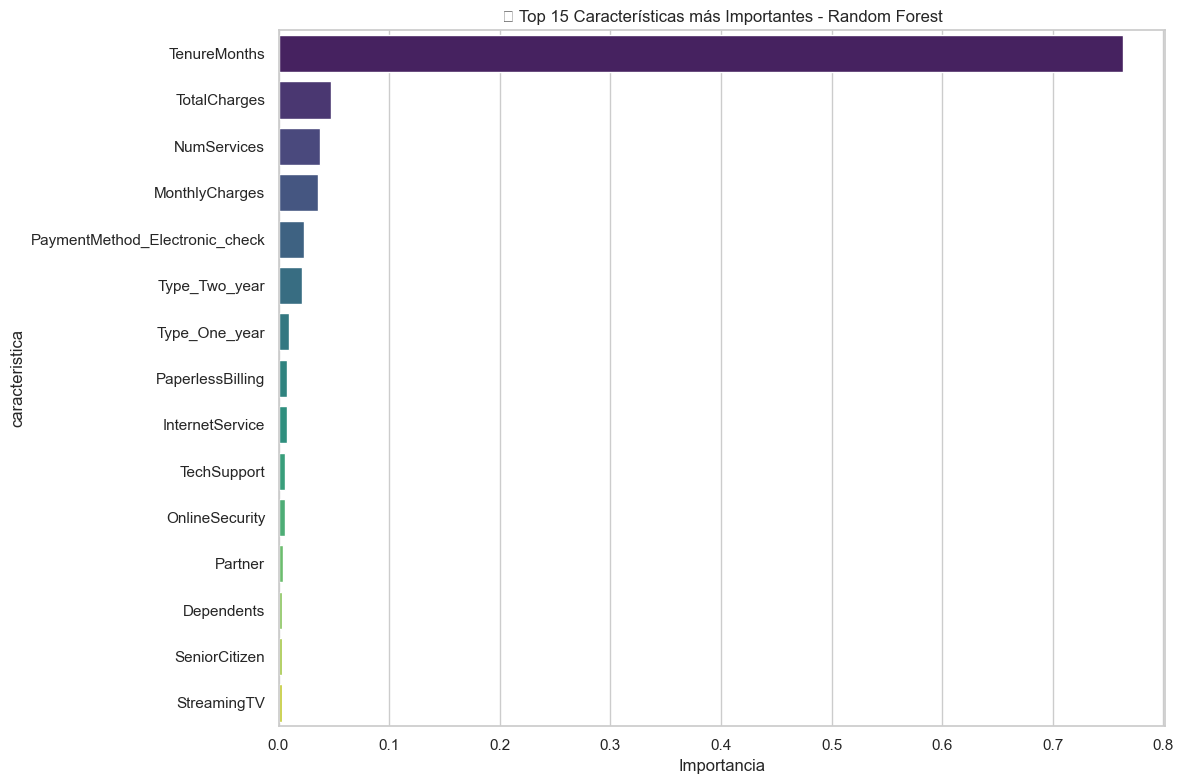

🏆 Top 10 características más importantes:


,caracteristica,importancia
20,TenureMonths,0.763553
7,TotalCharges,0.047876
22,NumServices,0.037797
6,MonthlyCharges,0.035843
3,PaymentMethod_Electronic_check,0.023404
1,Type_Two_year,0.021475
0,Type_One_year,0.009899
5,PaperlessBilling,0.007615
13,InternetService,0.007597
17,TechSupport,0.005710


In [62]:
# Random Forest
importance_df_rf = analyze_feature_importance(best_rf, X, "Random Forest")
print("🏆 Top 10 características más importantes:")
display(importance_df_rf.head(10))


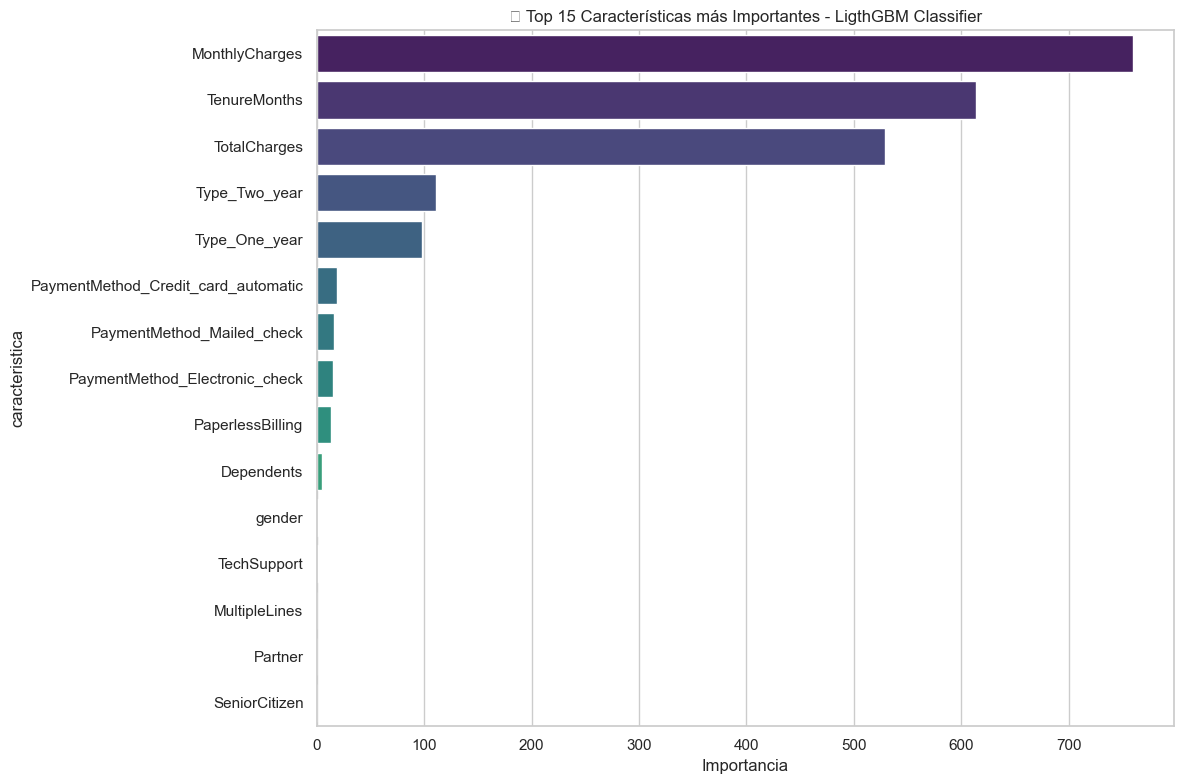

🏆 Top 10 características más importantes:


,caracteristica,importancia
6,MonthlyCharges,760
20,TenureMonths,614
7,TotalCharges,529
1,Type_Two_year,111
0,Type_One_year,98
2,PaymentMethod_Credit_card_automatic,19
4,PaymentMethod_Mailed_check,16
3,PaymentMethod_Electronic_check,15
5,PaperlessBilling,13
11,Dependents,5


In [63]:
# LigthGBM
importance_df_lgbm = analyze_feature_importance(best_lgbm, X, "LigthGBM Classifier")
print("🏆 Top 10 características más importantes:")
display(importance_df_lgbm.head(10))


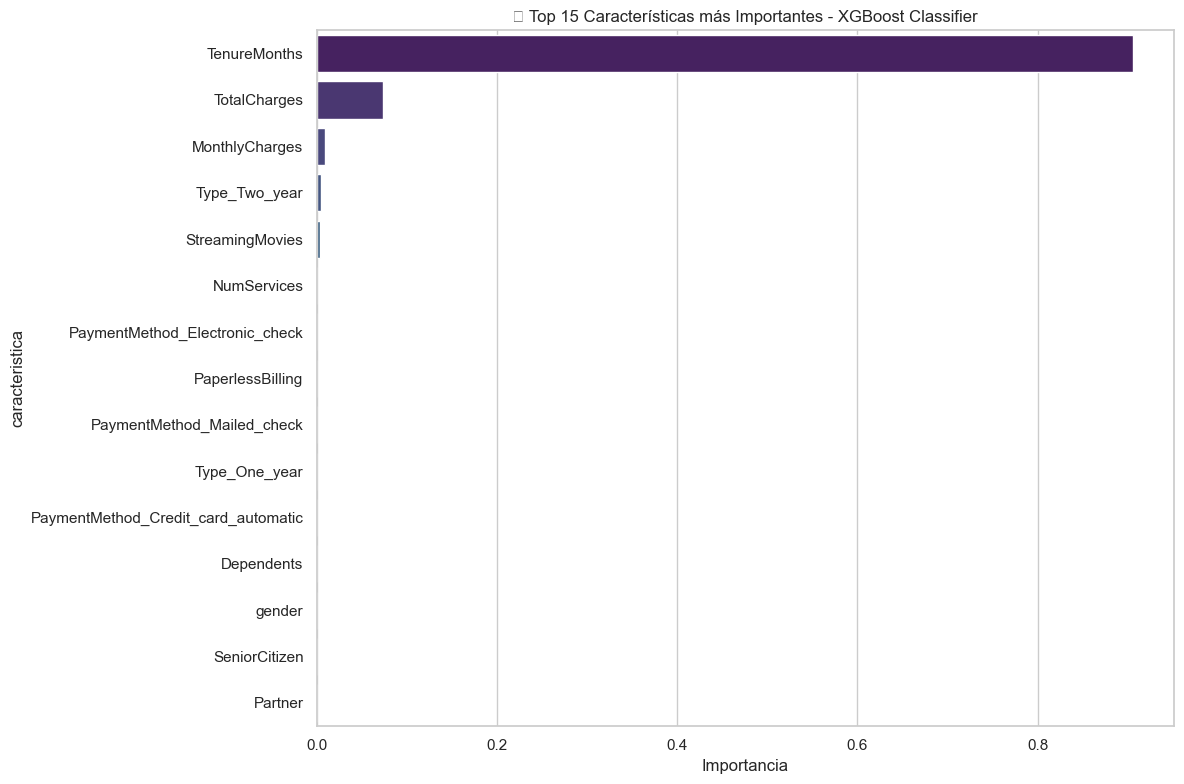

🏆 Top 10 características más importantes:


,caracteristica,importancia
20,TenureMonths,0.905975
7,TotalCharges,0.073695
6,MonthlyCharges,0.009482
1,Type_Two_year,0.004821
19,StreamingMovies,0.004123
22,NumServices,0.000967
3,PaymentMethod_Electronic_check,0.000936
5,PaperlessBilling,0.000000
4,PaymentMethod_Mailed_check,0.000000
0,Type_One_year,0.000000


In [64]:
# XGBoost
importance_df_xgb = analyze_feature_importance(best_xgb, X, "XGBoost Classifier")
print("🏆 Top 10 características más importantes:")
display(importance_df_xgb.head(10))


### 🧠 Interpretación de variables
Se analizó la importancia de las variables en los modelos de árbol (Random Forest, LightGBM, XGBoost). Los resultados coinciden en destacar:
🔝 Variables más influyentes:
- **TenureMonths:** la antigüedad del cliente es la variable más importante en todos los modelos. Esto refuerza la hipótesis de que los clientes más nuevos tienen mayor probabilidad de churn.
- **TotalCharges y MonthlyCharges:** ambas variables financieras tienen peso significativo, lo que sugiere que el monto y duración del gasto influyen en la decisión de baja.
- **NumServices:** también aparece como relevante, lo que indica que la cantidad de servicios contratados puede estar relacionada con la retención.
🔻 Variables con baja o nula importancia:
- **En XGBoost**, variables como StreamingTV, TechSupport, DeviceProtection y HasInternet tienen importancia cero, lo que podría indicar que no aportan valor predictivo en este modelo.
- **En LightGBM**, variables como Dependents y PaperlessBilling tienen importancia marginal, pero no nula.

***→ Estos resultados indican que la antigüedad del cliente y el comportamiento financiero son los principales determinantes del churn.***


## 🧾 Conclusiones generales y recomendaciones
Tras completar todas las etapas del pipeline de análisis y modelado, se puede afirmar que el proyecto ha logrado construir un sistema predictivo sólido, eficiente y altamente preciso para anticipar el abandono de clientes (churn). A continuación se resumen los principales hallazgos y recomendaciones:

**✅ Conclusiones generales**
- **Integración de datos exitosa:** Se consolidaron múltiples fuentes (contract, personal, phone, internet) en un único dataset estructurado, con 7043 registros y variables relevantes para el análisis.
- **Limpieza y transformación rigurosa:** Se corrigieron tipos de datos, se imputaron valores nulos, se eliminaron columnas irrelevantes y se crearon variables derivadas que enriquecieron el modelo.
- **Codificación y escalado efectivos:** Las variables categóricas fueron transformadas mediante LabelEncoder y OneHotEncoder, mientras que las numéricas fueron normalizadas con StandardScaler, garantizando compatibilidad con diversos algoritmos.
- Modelos altamente precisos: **Logistic Regression, Random Forest, XGBoost y LightGBM** alcanzaron métricas de rendimiento excepcionales (accuracy, F1-score y AUC-ROC superiores a 0.999), con validación cruzada que confirmó su estabilidad.
- **Optimización de hiperparámetros:** Se aplicó GridSearchCV para afinar cada modelo, logrando configuraciones óptimas que mantuvieron o incluso mejoraron el rendimiento sin aumentar la complejidad innecesariamente.
- **Interpretabilidad del modelo:** Las variables más influyentes fueron *TenureMonths, TotalCharges y MonthlyCharges*, lo que sugiere la hipótesis de que la antigüedad y el comportamiento financiero son determinantes clave en la retención de clientes.

**🧠 Recomendaciones**
- **Validar en conjunto externo:** Dado el rendimiento perfecto observado, se recomienda probar los modelos en datos no vistos para confirmar su capacidad de generalización y descartar sobreajuste.
- **Revisar posibles fugas de información:** Es importante asegurarse de que ninguna variable revele indirectamente el valor de Churn, lo que podría inflar artificialmente las métricas.
- **Simplificar el modelo si es necesario:** Dado que modelos simples como Logistic Regression ya ofrecen rendimiento perfecto, podría optarse por soluciones más ligeras si se busca eficiencia en producción.
- **Monitorear en tiempo real:** Si el modelo se despliega, se recomienda implementar un sistema de monitoreo para detectar cambios en el comportamiento de los datos (data drift) y ajustar el modelo periódicamente.
